In [1]:
from copy import copy
from time import time

import matplotlib.pyplot as plt
import pandas as pd

from HARK.Calibration.Income.IncomeTools import (
    CGM_income,
    parse_income_spec,
    parse_time_params,
)
from HARK.ConsumptionSaving.ConsBequestModel import (
    TerminalBequestWarmGlowConsumerType,
    init_lifecycle,
)
from HARK.datasets.life_tables.us_ssa.SSATools import parse_ssa_life_table
from HARK.datasets.SCF.WealthIncomeDist.SCFDistTools import income_wealth_dists_from_scf
from HARK.utilities import plot_funcs

In [2]:
birth_age = 25
death_age = 90
adjust_infl_to = 1992
income_calib = CGM_income
education = "College"

# Income specification
income_params = parse_income_spec(
    age_min=birth_age,
    age_max=death_age,
    adjust_infl_to=adjust_infl_to,
    **income_calib[education],
    SabelhausSong=True,
)

# Initial distribution of wealth and permanent income
dist_params = income_wealth_dists_from_scf(
    base_year=adjust_infl_to, age=birth_age, education=education, wave=1995
)

# We need survival probabilities only up to death_age-1, because survival
# probability at death_age is 1.
liv_prb = parse_ssa_life_table(
    female=True, cross_sec=True, year=2004, min_age=birth_age, max_age=death_age - 1
)

# Parameters related to the number of periods implied by the calibration
time_params = parse_time_params(age_birth=birth_age, age_death=death_age)

# Update all the new parameters
params = copy(init_lifecycle)
params.update(time_params)
params.update(dist_params)
params.update(income_params)
params.update({"LivPrb": [1.0] * len(liv_prb)})

In [3]:
# Make and solve an idiosyncratic shocks consumer with a finite lifecycle
LifecycleExample = TerminalBequestWarmGlowConsumerType(**params)
# Make this consumer live a sequence of periods exactly once
LifecycleExample.cycles = 1

In [4]:
start_time = time()
LifecycleExample.solve()
end_time = time()
print(f"Solving a lifecycle consumer took {end_time - start_time} seconds.")
LifecycleExample.unpack("cFunc")

Solving a lifecycle consumer took 0.21637511253356934 seconds.


Consumption functions


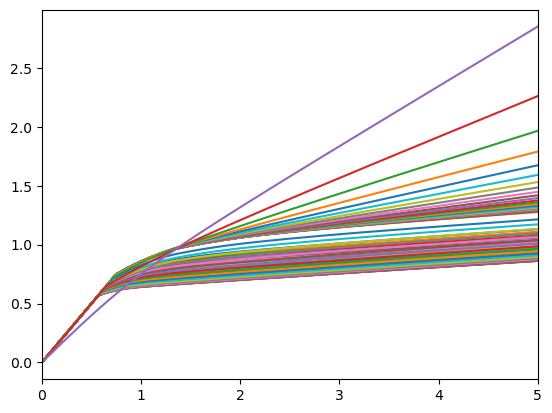

In [5]:
# Plot the consumption functions
print("Consumption functions")
plot_funcs(LifecycleExample.cFunc, 0, 5)

In [6]:
# Number of LifecycleExamples and periods in the simulation.
LifecycleExample.AgentCount = 500
LifecycleExample.T_sim = 200

# Set up the variables we want to keep track of.
LifecycleExample.track_vars = ["aNrm", "cNrm", "pLvl", "t_age", "mNrm"]

# Run the simulations
LifecycleExample.initialize_sim()
LifecycleExample.simulate()

{'aNrm': array([[0.29107451, 0.97280567, 0.35954438, ..., 1.79128979, 2.87113213,
         0.24403776],
        [0.24070812, 0.97288008, 0.64233056, ..., 1.74213882, 1.85747784,
         0.14811129],
        [0.61421345, 1.91344954, 0.62952155, ..., 1.42813418, 2.64318234,
         0.97507349],
        ...,
        [2.56352651, 0.23402007, 0.23623742, ..., 0.5171257 , 5.04996011,
         0.44550886],
        [3.00812144, 0.22463787, 0.43146558, ..., 1.01291716, 5.00984403,
         0.38658999],
        [3.62829475, 0.39381887, 0.75778414, ..., 2.20148144, 3.24979487,
         0.4595384 ]]),
 'cNrm': array([[0.83174537, 0.93405505, 0.85037923, ..., 0.9970776 , 1.0686868 ,
         0.81628909],
        [0.80518163, 0.91788899, 0.88481538, ..., 0.97480792, 0.98258258,
         0.76681428],
        [0.87186135, 0.9720065 , 0.8737382 , ..., 0.93998421, 1.01770246,
         0.90665668],
        ...,
        [1.01281367, 0.79704645, 0.79783511, ..., 0.85916496, 1.15920502,
         0.8480717

In [7]:
raw_data = {
    "Age": LifecycleExample.history["t_age"].flatten() + birth_age - 1,
    "pIncome": LifecycleExample.history["pLvl"].flatten(),
    "nrmM": LifecycleExample.history["mNrm"].flatten(),
    "nrmC": LifecycleExample.history["cNrm"].flatten(),
}

Data = pd.DataFrame(raw_data)
Data["Cons"] = Data.nrmC * Data.pIncome
Data["M"] = Data.nrmM * Data.pIncome

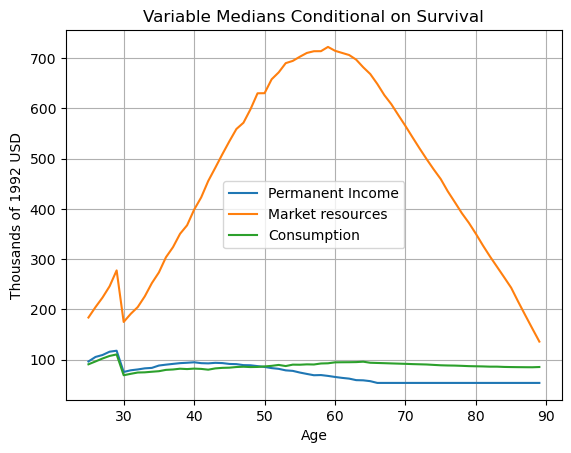

In [8]:
# Find the mean of each variable at every age
AgeMeans = Data.groupby(["Age"]).median().reset_index()

plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Permanent Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Thousands of {} USD".format(adjust_infl_to))
plt.title("Variable Medians Conditional on Survival")
plt.grid()